# DI 504 Lab 3
### Hyperparameter search for forecasting sunspot numbers

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import Tuple

import tqdm
import wandb
import onnx

### 1) Data

This lab was partially inspired by Arif Ozan Kızıldağ's LSTM univariate time series lab. It includes code jointly prepared by our project course team. (Thanks to Bevan Deniz Çılğın and Tizian Peer for their input.)

Here our aim will be to forecast the total number of sunspots on the sun for the next month. Sunspots allow scientists to track where the sun is on its cycle. Currently we are in a maximum period as seen in the graph.

<Axes: xlabel='y-frac', ylabel='m'>

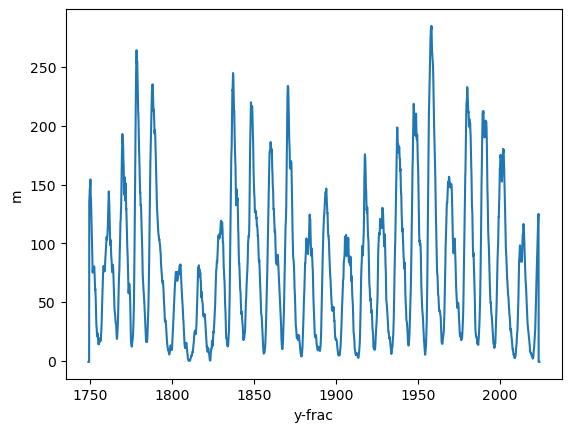

In [2]:
data = pd.read_csv('SN_ms_tot_V2.0.csv', sep=';', header=None)

data.columns = ['yyyy','mm','y-frac','m','sd','n','provisional']

sns.lineplot(x="y-frac", y="m", data=data)

This dataset was averaged over 13 month periods, hence the -1 values at the start and end. We will filter them out below.

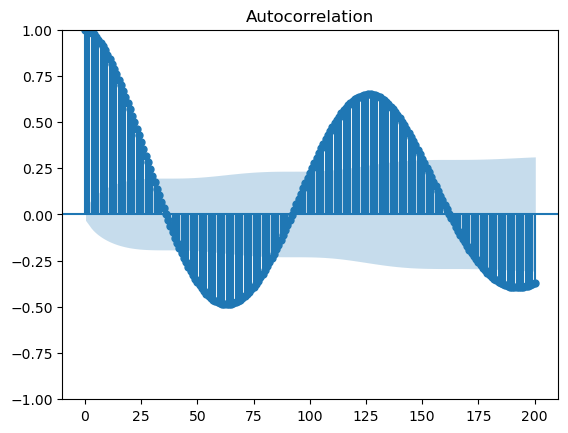

In [3]:
series = data.m.values.reshape(-1,1)[6:-6]


plot_acf(series, lags=200)
plt.show()

Some time series background: Autocorrelation is the correlation of a time series to itself. Things get different when we shift the series back and measure the correlation to the original series. (i.e. how much the change in the previous step correlates with the change today.)

This loosely will give us an idea about the periodicity of our signal. (There are better ways of doing this of course, like with fourier analysis.)

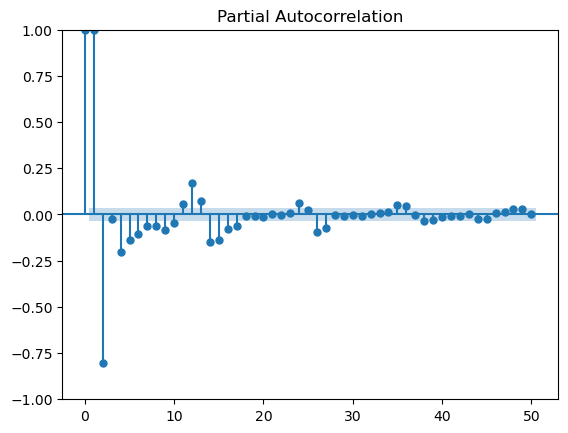

(-10.400304328749788, 1.917155469297659e-18, 29, 3258, {'1%': -3.4323587353357996, '5%': -2.8624275393930216, '10%': -2.5672424561649447}, 10586.311689779579)


In [4]:
plot_pacf(series, lags=50)
plt.show()

print(adfuller(series))

Here we see the amount of additional "information" each lag contains. We will not focus on this part too much. Our data is stationary according to the augmented dicky fuller test, which is a good sign when it comes to time series predictions. (As an LSTM won't be too good when there is a trend in the data.)

In [5]:
maxima = acf(series,nlags=200)[100:150].max()

np.where(acf(series, nlags=200) == maxima)

(array([126], dtype=int64),)

We can see our dataset has a periodicity of around 126 months, which corresponds to 10.5 years. This is around the same value if one searches for how long a solar cycle lasts for.

### 2) Create dataset for one step ahead predictions

In [6]:
def split_sequences(inseq: np.array, outseq: np.array, 
                    nin: int, nout: int, step: int) -> Tuple[np.array, np.array]:
    
    X, y = list(), list()
    
    for i in range(0, len(inseq), step):
        end_ix = i + nin
        out_end_idx = end_ix + nout
        
        if out_end_idx > len(inseq): break
        
        seq_x, seq_y = inseq[i:end_ix], outseq[end_ix:out_end_idx]
        
        X.append(seq_x), y.append(seq_y)

        x_t = torch.tensor(np.array(X), dtype=torch.float32)
        y_t = torch.tensor(np.array(y), dtype=torch.float32)
    return x_t, y_t

We can train an LSTM model by two approaches. One involves taking n lags (previous values) as inputs to predict the next value in the sequence. This is one step ahead prediction.

An alternative approach is to predict multiple time steps ahead. Generally these types of problems are harder to solve, so we won't focus on that.

When forecasting unseen data, we can either forecast one interval and move that same interval (we predict x sun spots for i'th month, and y for the i+1st month). To forecast any further with the same data the prediction itself can be treated as the reality, but this can propoagate the error of previous predictions.

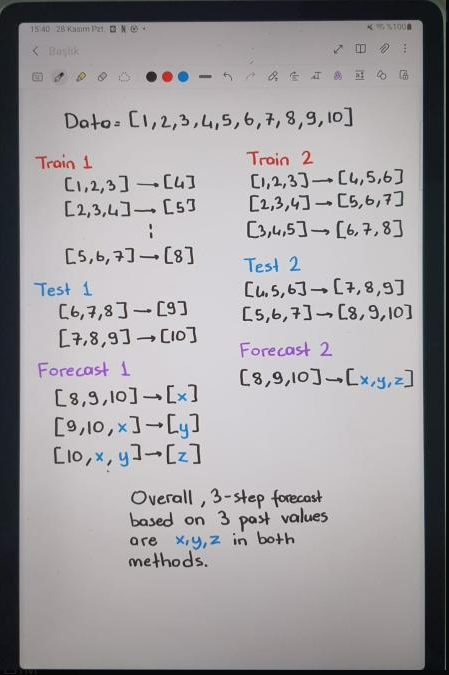

Here we will scale the data with the range of the training set (corresponding to about 15 cycles). Our validation set will be used for tracking and finding best models in wandb and the test set will be used for a final test.

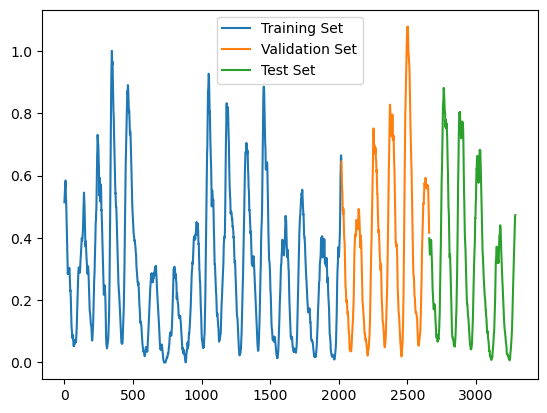

In [7]:
mm = MinMaxScaler()

train = series[:2020].reshape(-1,1) # ~128*15

train = mm.fit_transform(train)
val = mm.transform(series[2020:2660]) # 128*5
test = mm.transform(series[2660:]) # 128*5

plt.plot(range(2020),train,label='Training Set')
plt.plot(range(2020,2660),val,label='Validation Set')
plt.plot(range(2660,len(series)),test,label='Test Set')
plt.legend()

We will predict 1 value ahead given 128 lags (~one cycle).

In [8]:
input_size, output_size = 128, 1

train_X, train_y = split_sequences(train, train, input_size,output_size,1)
val_X, val_y = split_sequences(val, val, input_size,output_size,1)
test_X, test_y = split_sequences(test, test, input_size,output_size,1)

train_ds = TensorDataset(train_X, train_y)
val_ds = TensorDataset(val_X, val_y)
test_ds = TensorDataset(test_X, test_y)

### 3) LSTM model definition

LSTM (short for long-short term memory) is a model designed to capture useful representations of sequential data. LSTM networks have what is called as a cell state and hidden state. The hidden state has an internal dimension (hidden size) and as new data arrives this hidden state will be updated based on certain rules that ensures the model has memory of the past but is flexible enough for future changes.

The figure below depicts a stacked LSTM, where internal representations are used for another round of learning. At the end, either the outputs can be used, or the hidden state can be used as a feature extraction mechanism where linear layers can be attached to it. This is what will be done below. The last hidden state carries the "deepest" features, and only those will be incorporated.

LSTM's and other sequence models will be covered in detail in next semester's course, but for this part we will utilize a given model definition and search through some hyperparameters.

![](https://i.stack.imgur.com/QxzoG.png)

In [9]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

seed = 1337

torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

class LSTM(nn.Module):
    
    def __init__(self, horizon, input_size, hidden_size, 
                hidden_ln, num_layers, drop, device):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=drop)
        
        self.fc_1 =  nn.Linear(hidden_size, hidden_ln)  
        self.fc_2 = nn.Linear(hidden_ln, horizon) 
        self.relu = nn.ReLU()
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight.data, nonlinearity='relu')
        if isinstance(module, nn.LSTM):
            for w in module.all_weights[0]:
                nn.init.normal_(w)
        
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        final = hn[-1]
        final = final.view(-1, self.hidden_size)
        out = self.relu(final)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        return out

params = {'horizon' : 1,
          'input_size' : 1,
          'hidden_size' : 2,
          'hidden_ln' : 8,
          'num_layers' : 3,
          'drop' : 0.3,
          'device' : device}

lstm = LSTM(**params).to(device)

Couple of notes: notice how the model has an internal "init weights" method that is only called in the initiation phase. This ensures the linear and lstm layer weights follow a certain distribution once initialized. LSTM hidden states and cell states have to be manually initialized.

#### 3.1) Training helpers

In [10]:
n_epochs = 250
learning_rate = 0.00030299873510180057
batch_size = 64

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=False, drop_last=False)

val_loader = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False,
                        drop_last=False)

test_loader = DataLoader(test_ds, batch_size=len(val_ds),
                         shuffle=False, drop_last=False)

In [11]:
def training(model, optimiser, loss_fn, traindataloader, device):
    losses = 0
    model.train()
    for x, y in traindataloader:
        outputs = model(x.to(device))
        optimiser.zero_grad()
        loss = loss_fn(outputs, y.to(device))
        loss.backward()
        optimiser.step()
        losses += loss.item()
    return losses / (len(traindataloader)*y.shape[1]) # loss per forecasted time unit
        
def eval(model, loss_fn, valloader, device):    
    losses = 0
    model.eval()
    for x, y in valloader:
        val_preds = model(x.to(device))
        val_loss = loss_fn(val_preds, y.to(device))
        losses += val_loss.item()
        
    return losses / (len(valloader)*y.shape[1])

### 4) Training

In [12]:
train_losses = []
val_losses = []

train_ma = []
val_ma = []

best_val_loss = np.inf

for i in tqdm.tqdm(range(n_epochs)):
    
    loss_t = training(lstm, optimiser, loss_fn,
                          train_loader, device)

    loss_v = eval(lstm, loss_fn, val_loader, device)

    train_ma.append(loss_t)
    val_ma.append(loss_v)

    if i%5==0:
        train_losses.append(np.mean(train_ma))
        val_losses.append(np.mean(val_ma))    
        train_ma = []
        val_ma = []

    # if loss_v < best_val_loss:
    #     best_val_loss = loss_v
    #     torch.save(lstm, "best_model.pt")

  0%|          | 0/250 [00:00<?, ?it/s]c:\ProgramData\miniconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\ProgramData\miniconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([36, 1, 1])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\ProgramData\miniconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([512, 1, 1])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcas

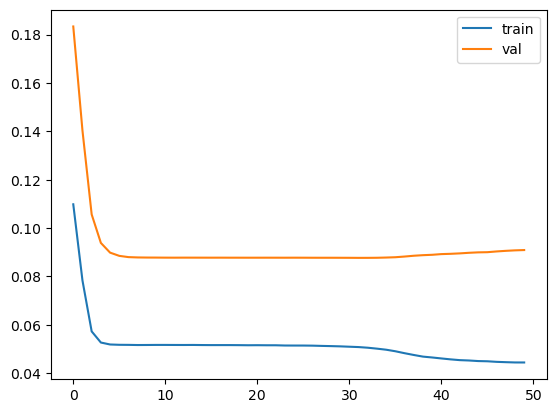

In [13]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train','val'])

In [14]:
np.mean(val_losses[-5:])

0.09051589161157608

This is not the same validation loss for the experiment.

Inspecting predictions against ground truth we see the model doesn't perform very good.

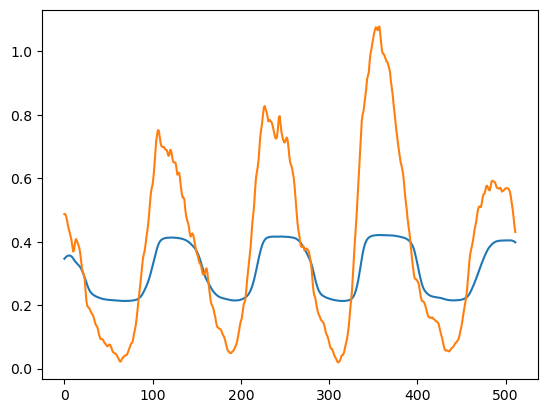

In [15]:
preds = lstm(val_X.to(device)).detach().cpu().numpy()
plt.plot(preds)
x, y = next(iter(val_loader))
plt.plot(x[:,127])

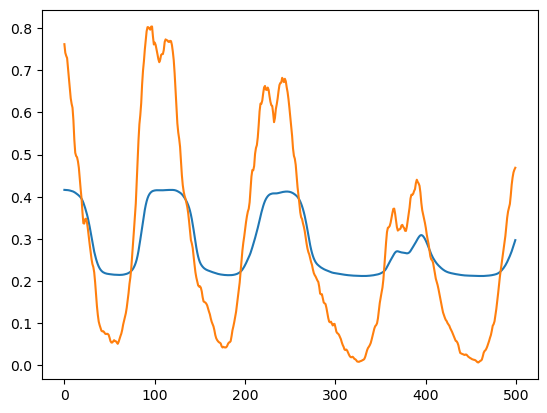

In [16]:
preds = lstm(test_X.to(device)).detach().cpu().numpy()
plt.plot(preds)
x, y = next(iter(test_loader))
plt.plot(x[:,127])

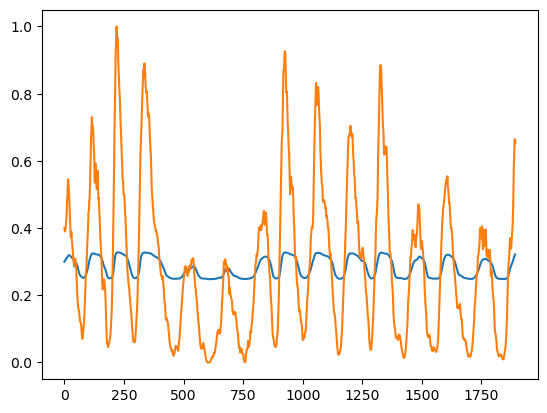

In [24]:
preds = lstm(train_X.to(device)).detach().cpu().numpy()
plt.plot(preds)
plt.plot(train[127:])

### 5) W&B sweep

The above model parameters were found throuhgh a bayesian search. It missed two things:

1) Relatiely simple solutions (sometimes even leading to straight lines) can give good loss, forcing the algorithm to learn those patterns and not giving enough chance to other combinations.

2) The runs are not replicable since all models are randomly initialized.

To avoid these issues, try this experiment on your own with these modifications:

1) Do a random search, and set the number of runs accordingly.

2) Either set a random seed, or save a model as a pt object and log it with `wandb.save()`

In [ ]:
wandb.login()

sweep_config = {
    "name": "sweep-1",
    "method": "bayes",
    "metric": {
      "name": "val_loss",
      "goal": "minimize"   
    },
    "parameters": {
        "num_layers": {
            "values": [1,2,3]
        },
        "hidden_size": {
            "values": [1,2,4,8,16]
        },
        "hidden_ln": {
            "values": [4,8,16,32,64]
        },
        "dropout": {
            "values": [0,0.1,0.2,0.3,0.4]
        },
        "learning_rate": {
            "distribution": 'log_uniform_values',
            "min": 1e-4,
            "max": 1e-2
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="solar_activity")

n_epochs = 250

demo_x, _ = next(iter(train_loader)) # for onnx I/0 dims

def run_sweep():

    with wandb.init():
        
        config = wandb.config

        params = {'horizon' : 1,
                  'input_size' : 1,
                  'hidden_size' : config.hidden_size,
                  'hidden_ln' : config.hidden_ln,
                  'num_layers' : config.num_layers,
                  'drop' : config.dropout,
                  'device' : device}

        seed = 1337

        torch.manual_seed(seed)
        if device == 'cuda':
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        lstm2 = LSTM(**params).to(device)
        
        loss_fn = torch.nn.MSELoss()
        optimiser = torch.optim.Adam(lstm2.parameters(), lr=config.learning_rate)

        val_loss = []
        train_loss = []

        for i in range(n_epochs):
            
            loss_t = training(lstm2, optimiser, loss_fn,
                                  train_loader, device)

            loss_v = eval(lstm2, loss_fn, val_loader, device)
            
            val_loss.append(loss_v)
            train_loss.append(loss_t)
            
            if i%5==0:

                wandb.log({'val_loss' : np.mean(val_loss),
                           'train_loss' : np.mean(train_loss)})

                val_loss = []
                train_loss = []

wandb.agent(sweep_id, run_sweep, count=5)